# Breast Dataset

In [5]:
import sys  
sys.path.insert(0, '../')
import deep_forest
import preprocess
import torch as th
from torch import nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from math import pi
import seaborn as sns
from tqdm import tqdm
sns.set_theme("notebook")
sns.set_style('whitegrid')

## Generate Data

In [6]:
x, y, _, _ = preprocess.get_data(100)

## Deep Forest

In [7]:
model = deep_forest.DeepForest(100, 2, 30, 0.25, 10)
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)
x = x.to(device)
y = y.to(device)

In [14]:
optimizer = th.optim.Adam(model.parameters())
pbar = tqdm(range(2500))
for i in pbar:
    model.populate_best(x[:, :], y[:])
    optimizer.zero_grad()

    loss = model.loss(x[:, :], y[:], device)
    loss.backward()
    optimizer.step()

    pbar.set_description("EPOCH %d || Acc: %s || Loss: %s" % (i, str(th.mean((model.forward(x[:, :], device) == y[:]).float())), str(loss)))

print("\n\n==============\nFINAL ACC: %s" % str(th.mean((model.forward(x[:, :], device) == y[:]).float())))

EPOCH 1499 || Acc: tensor(0.9824) || Loss: tensor([295.2852], grad_fn=<AddBackward0>): 100%|██████████| 1500/1500 [23:46<00:00,  1.05it/s]

FINAL ACC: tensor(0.9824)



In [15]:
imp = model.compute_importance(x)
print()
print(imp)

100%|██████████| 100/100 [08:28<00:00,  5.09s/it]
defaultdict(<function DeepForest.__init__.<locals>.<lambda> at 0x7fcd0ec0af28>, {8: 0.0027047572948998345, 9: 0.003186862722877876, 20: 0.06474466372822707, 6: 0.02537344181808636, 19: 0.0006549109533266996, 12: 0.0216813285128525, 14: 0.000328634614132792, 3: 0.08663024882366967, 5: 0.009818292517484934, 4: 0.0022308356030347415, 26: 0.033038960684237575, 0: 0.12289487600583164, 23: 0.17658388819422347, 13: 0.07179940693123754, 28: 0.014400209328548493, 29: 0.004151410116500927, 10: 0.01993187290848892, 15: 0.004646737510479714, 7: 0.021724177446016527, 21: 0.029172069569501163, 27: 0.019876897699647515, 17: 0.0008432234707473053, 2: 0.12979642858820126, 1: 0.01479641521562952, 11: 0.011745696606563565, 24: 0.0035693942737793833, 16: 0.006059795060458612, 18: 0.0017799931530238285, 25: 0.014218604122739882, 22: 0.08161596652555059})



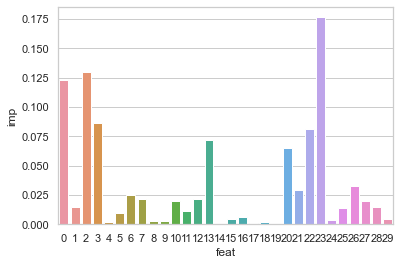

In [16]:
import pandas as pd
data = pd.DataFrame({"feat": list(imp.keys()), "imp": list(imp.values())})
sns.barplot(x="feat", y="imp", data=data)

## MLP Baseline

In [11]:
mlp = nn.Sequential(
    nn.Linear(30, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 25),
    nn.LeakyReLU(),
    nn.Linear(25, 2),
    nn.Softmax()
)

optimizer = th.optim.Adam(mlp.parameters())
pbar = tqdm(range(1000))
for i in pbar:
    optimizer.zero_grad()

    preds = mlp(x)
    loss = nn.functional.cross_entropy(preds, y)
    loss.backward()
    optimizer.step()

    pbar.set_description("EPOCH %d || Acc: %s || Loss: %s" % (i, str(th.mean((th.argmax(mlp(x), 1) == y).float())), str(loss)))

print("\n\n==============\nFINAL ACC: %s" % str(th.mean((th.argmax(mlp(x[:]), 1) == y[:]).float())))

EPOCH 999 || Acc: tensor(0.6274) || Loss: tensor(0.6858, grad_fn=<NllLossBackward>): 100%|██████████| 1000/1000 [00:07<00:00, 128.56it/s]

FINAL ACC: tensor(0.6274)



## Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2)
clf.fit(x[:, :].numpy(), y[:].numpy())
print(clf.score(x[:, :].numpy(), y[:].numpy()))

0.9630931458699473


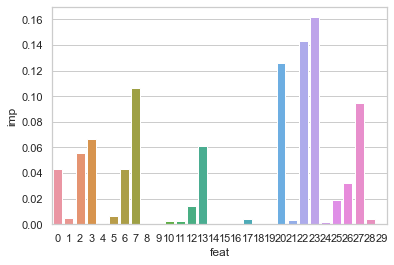

In [13]:
data = pd.DataFrame({"feat": list(range(30)), "imp": clf.feature_importances_})
sns.barplot(x="feat", y="imp", data=data)